# Test Best Models

Test notebook to generate the statistics of the different models found with AMS. First load the required libraries

In [1]:
import datetime
import logging
import sys
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
from keras.models import model_from_json

from sklearn.model_selection import KFold
from scipy import stats

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
sys.path.append('/media/controlslab/DATA/Projects')

import ann_framework.aux_functions as aux_functions

import automatic_model_selection
from automatic_model_selection import Configuration
from ann_encoding_rules import Layers
import fetch_to_keras
#from CMAPSAuxFunctions import TrainValTensorBoard

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression, SequenceTunableModelClassification

#Data handlers
from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.data_handlers.data_handler_MNIST import MNISTDataHandler
from ann_framework.data_handlers.data_handler_CIFAR10 import CIFAR10DataHandler

import seaborn as sns; sns.set(font_scale=1.2)

%matplotlib inline

Using TensorFlow backend.


### Given a model, get the compiled model

In [2]:
def get_compiled_model(model, problem_type, optimizer_params=[]):
    """Obtain a keras compiled model"""
    
    #Shared parameters for the models
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    
    return model


def create_tunable_model(model_genotype, problem_type, input_shape, data_handler, model_number):
    
    K.clear_session()
    
    model = fetch_to_keras.decode_genotype(model_genotype, problem_type, input_shape, 1)
    
    model = get_compiled_model(model, problem_type, optimizer_params=[])
    
    if problem_type == 1:
        tModel = SequenceTunableModelRegression('ModelReg_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
    else:
        tModel = SequenceTunableModelClassification('ModelClass_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
        
    return tModel

### Load cmaps data handler

In [3]:
def cmapss_dhandler(data_scaler=None):

    #Selected as per CNN paper
    features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
    'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
    selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
    selected_features = list(features[i] for i in selected_indices-1)
    data_folder = '../CMAPSSData'

    window_size = 24
    window_stride = 1
    max_rul = 129

    dhandler_cmapss = CMAPSSDataHandler(data_folder, 1, selected_features,
                                       max_rul, window_size, window_stride, data_scaler=data_scaler)

    input_shape = (len(selected_features)*window_size, )

    return dhandler_cmapss

### Load models and evaluate model

In [4]:
def load_model(model_file, weights_file="", problem_type=1):
    
    p_type = ""
    
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Loaded model from disk") 
        
    #Load weights if specified
    if weights_file != "":
        # load weights into new model
        loaded_model.load_weights(weights_file)
        print("Loaded weights from disk") 
    else:
        print("Model needs training")
        
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        p_type = "regression"
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        p_type = "classification"
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    print("Created model for " + p_type + " with loss function " + lossFunction)

    return loaded_model
        
        

### Load each of the models and test them

In [5]:
best_model_folder = 'best_models'
"""
test_sets = {'cifar10':(CIFAR10DataHandler, None, 2), 
             'cmapss':(cmaps_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1), 
             'mnist':(MNISTDataHandler, None, 2)}
"""

#test_sets = {'cmapss':(cmapss_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1)}
test_sets = {'mnist':(MNISTDataHandler, None, 2)}
#alpha_folders = ['alpha0.6', 'alpha0.8', 'alpha1']
#alpha_folders = ['alpha0.5']
#alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = {}

k = 5  #For 5-fold cross validation
evaluations_cv = np.zeros(k)
evaluations_test = np.zeros(k)

In [6]:
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

#alpha_values = [0.5]


for dataset in test_sets.keys():
    for alphaValue in alpha_values:
        
        model_file_name = 'yulin/alpha{}/bestModel_global.json'.format(alphaValue)
        weights_file_name = 'yulin/alpha{}/bestModel_global.h5'.format(alphaValue)
        trainable_count = 0
        
        print("Testing for "+model_file_name)
        
        results_key = dataset + "_" +  str(alphaValue)
        
        model_location = best_model_folder + '/' + dataset + '/' + model_file_name
        
        if weights_file_name != "":
            weights_location = best_model_folder + '/' + dataset + '/' + weights_file_name
        
        dhandler, data_scaler, problem_type = test_sets[dataset]
        
        #Create CV folds
        data_handler = dhandler(data_scaler=data_scaler)
        data_handler.load_data(verbose = 1, unroll=True)
        data_handler.print_data()
        folds = list(KFold(n_splits=k, shuffle=True).split(data_handler.X_train))

        #model = load_model(model_location, weights_location, problem_type)   
        
        print('Validation on model:' + model_location)
        
        for j, (train_idx, val_idx) in enumerate(folds):

            print('\nExperiment on Fold ', j)
            
            K.clear_session()  #Clear the previous tensorflow graph 

            X_train_cv = data_handler.X_train[train_idx]
            y_train_cv = data_handler.y_train[train_idx]
            X_valid_cv = data_handler.X_train[val_idx]
            y_valid_cv = data_handler.y_train[val_idx]

            model = load_model(model_location, "", problem_type)
            model.summary()
            trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))

            model.fit(X_train_cv, y_train_cv, batch_size=512, epochs=100, verbose=1)

            evaluation_cv = model.evaluate(X_valid_cv, y_valid_cv)
            evaluation_test = model.evaluate(data_handler.X_test, data_handler.y_test)

            evaluations_cv[j] = evaluation_cv[1]
            evaluations_test[j] = evaluation_test[1]
            
        results[results_key] = (evaluations_cv.copy(), evaluations_test.copy(), trainable_count)
        

Testing for yulin/alpha0.2/bestModel_global.json
Loading data. Cross-Validation ratio 0
Printing shapes

Training data (X, y)
(60000, 784)
(60000, 10)
Testing data (X, y)
(10000, 784)
(10000, 10)
Printing first 5 elements

Training data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Testing data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Validation on model:best_models/mnist/yulin/alpha0.2/bestModel_global.json

Experiment on Fold  0
Loaded model from disk
Model needs training
Created mo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0028 - acc: 0.9991
Epoch 64/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9987
Epoch 65/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9976
Epoch 66/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0028 - acc: 0.9993
Epoch 67/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 0.9995
Epoch 68/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0017 - acc: 0.9996
Epoch 69/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0023 - acc: 0.9993
Epoch 70/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0068 - acc: 0.9979
Epoch 71/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0029 - acc: 0.9991
Epoch 72/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0022 - acc: 0.9994
Epo

Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9969
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0074 - acc: 0.9981
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9974
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9978
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0061 - acc: 0.9984
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0056 - acc: 0.9988
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0058 - acc: 0.9983
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0051 - acc: 0.9987
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - acc: 0.9987
Epoch 42/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - ac

48000/48000 [==============================] - 0s 4us/step - loss: 0.0023 - acc: 0.9992
Epoch 84/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.9137e-04 - acc: 0.9998
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0012 - acc: 0.9996
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 0.9996
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0012 - acc: 0.9997
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0022 - acc: 0.9993
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0049 - acc: 0.9984
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0030 - acc: 0.9990
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9988
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0033 - acc: 0.9990

48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - acc: 0.9987
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0067 - acc: 0.9979
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9989
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0028 - acc: 0.9991
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0024 - acc: 0.9994
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0029 - acc: 0.9992
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9992
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 0.9990
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9988
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0057 - acc: 0.9982
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 8us/step - loss: 0.6659 - acc: 0.8259
Epoch 2/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.2600 - acc: 0.9254
Epoch 3/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1948 - acc: 0.9428
Epoch 4/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1564 - acc: 0.9541
Epoch 5/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1304 - acc: 0.9616
Epoch 6/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1124 - acc: 0.9668
Epoch 7/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0962 - acc: 0.9721
Epoch 8/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0831 - acc: 0.9764
Epoch 9/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0736 - acc: 0.9785
Epoch 10/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0651 - acc: 0.9810

48000/48000 [==============================] - 0s 5us/step - loss: 6.2721e-04 - acc: 1.0000
Epoch 48/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.8024e-04 - acc: 1.0000
Epoch 49/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.3324e-04 - acc: 1.0000
Epoch 50/100
48000/48000 [==============================] - 0s 5us/step - loss: 4.9391e-04 - acc: 1.0000
Epoch 51/100
48000/48000 [==============================] - 0s 5us/step - loss: 4.5377e-04 - acc: 1.0000
Epoch 52/100
48000/48000 [==============================] - 0s 5us/step - loss: 4.2221e-04 - acc: 1.0000
Epoch 53/100
48000/48000 [==============================] - 0s 5us/step - loss: 3.8659e-04 - acc: 1.0000
Epoch 54/100
48000/48000 [==============================] - 0s 5us/step - loss: 3.6360e-04 - acc: 1.0000
Epoch 55/100
48000/48000 [==============================] - 0s 5us/step - loss: 3.3587e-04 - acc: 1.0000
Epoch 56/100
48000/48000 [==============================] - 0s 5us/s

48000/48000 [==============================] - 0s 5us/step - loss: 7.9632e-05 - acc: 1.0000
Epoch 93/100
48000/48000 [==============================] - 0s 5us/step - loss: 7.5966e-05 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 5us/step - loss: 7.1765e-05 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 5us/step - loss: 6.8248e-05 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 5us/step - loss: 6.4499e-05 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 5us/step - loss: 6.1903e-05 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.8472e-05 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.5445e-05 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 14us/step

Experiment on Fold  3
Loaded model from disk
Model needs training
Created model for classification

48000/48000 [==============================] - 0s 4us/step - loss: 0.0073 - acc: 0.9987
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0092 - acc: 0.9979
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0067 - acc: 0.9988
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0055 - acc: 0.9991
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0.9992
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9995
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0049 - acc: 0.9989
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1879 - acc: 0.9602
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0208 - acc: 0.9936
Epoch 36/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0099 - acc: 0.9976
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7548 - acc: 0.7960
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2838 - acc: 0.9188
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2219 - acc: 0.9356
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1881 - acc: 0.9449
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1634 - acc: 0.9519
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1450 - acc: 0.9569
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1307 - acc: 0.9618
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1187 - acc: 0.9648
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1078 - acc: 0.9684
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0994 - acc: 0.9706

48000/48000 [==============================] - 0s 4us/step - loss: 0.0066 - acc: 0.9987
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0067 - acc: 0.9985
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0051 - acc: 0.9993
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9995
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0033 - acc: 0.9998
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9999
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0024 - acc: 1.0000
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0024 - acc: 0.9999
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0022 - acc: 1.0000
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0025 - acc: 0.9998
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7726 - acc: 0.7872
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2860 - acc: 0.9201
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2277 - acc: 0.9343
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1949 - acc: 0.9434
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1714 - acc: 0.9504
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1526 - acc: 0.9557
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1377 - acc: 0.9607
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1249 - acc: 0.9642
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1140 - acc: 0.9667
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1043 - acc: 0.9695

48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 0.9995
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9997
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9997
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0068 - acc: 0.9986
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0049 - acc: 0.9994
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0084 - acc: 0.9978
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0053 - acc: 0.9990
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9997
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9998
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0021 - acc: 0.9999
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 7.5696e-04 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 4us/step - loss: 7.0796e-04 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.6442e-04 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.3067e-04 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.9804e-04 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.7052e-04 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.5088e-04 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 14us/step

Experiment on Fold  1
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
____________________________________________________________

48000/48000 [==============================] - 0s 4us/step - loss: 0.0271 - acc: 0.9936
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0264 - acc: 0.9935
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0245 - acc: 0.9940
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0233 - acc: 0.9942
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0214 - acc: 0.9950
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0207 - acc: 0.9951
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0199 - acc: 0.9955
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0191 - acc: 0.9957
Epoch 42/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0172 - acc: 0.9964
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0165 - acc: 0.9965
Epo

Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1763 - acc: 0.9484
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1592 - acc: 0.9546
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1447 - acc: 0.9582
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1330 - acc: 0.9615
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1221 - acc: 0.9648
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1135 - acc: 0.9676
Epoch 11/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1046 - acc: 0.9699
Epoch 12/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0981 - acc: 0.9715
Epoch 13/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0910 - acc: 0.9731
Epoch 14/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0853 - acc: 0.

48000/48000 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9992
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0068 - acc: 0.9992
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0063 - acc: 0.9993
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0070 - acc: 0.9990
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0058 - acc: 0.9995
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0057 - acc: 0.9993
Epoch 63/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0050 - acc: 0.9995
Epoch 64/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0044 - acc: 0.9997
Epoch 65/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0044 - acc: 0.9997
Epoch 66/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9998
Epo

10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  1
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 48)                37680     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.8667 - acc: 0.7887
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3800 - acc: 0.9023
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3028 - acc: 0.9170
Epoch 4/100
48000/48000 [=====

48000/48000 [==============================] - 0s 4us/step - loss: 0.0352 - acc: 0.9928
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0338 - acc: 0.9936
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0326 - acc: 0.9940
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0314 - acc: 0.9941
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0301 - acc: 0.9947
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0290 - acc: 0.9950
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0279 - acc: 0.9950
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0269 - acc: 0.9953
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0260 - acc: 0.9957
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0248 - acc: 0.9961
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0038 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  4
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 48)                37680     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.8338 - acc: 0.8004
Epoch 2/100
48000/48000 [==

48000/48000 [==============================] - 0s 4us/step - loss: 0.1176 - acc: 0.9656
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1156 - acc: 0.9661
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1140 - acc: 0.9656
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1126 - acc: 0.9670
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1105 - acc: 0.9681
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1091 - acc: 0.9682
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1084 - acc: 0.9680
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1066 - acc: 0.9691
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1056 - acc: 0.9686
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1035 - acc: 0.9692
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0637 - acc: 0.9813
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0628 - acc: 0.9819
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0630 - acc: 0.9813
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0621 - acc: 0.9821
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0613 - acc: 0.9822
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0613 - acc: 0.9821
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0602 - acc: 0.9823
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0592 - acc: 0.9832
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0585 - acc: 0.9831
Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0581 - acc: 0.9830
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1312 - acc: 0.9609
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1292 - acc: 0.9617
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1268 - acc: 0.9626
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1254 - acc: 0.9627
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1229 - acc: 0.9637
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1200 - acc: 0.9644
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1189 - acc: 0.9643
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1183 - acc: 0.9649
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1147 - acc: 0.9666
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1135 - acc: 0.9662
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 1.1812 - acc: 0.6773
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.4357 - acc: 0.8831
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3382 - acc: 0.9041
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3010 - acc: 0.9141
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2776 - acc: 0.9195
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2587 - acc: 0.9250
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2432 - acc: 0.9295
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2296 - acc: 0.9337
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2177 - acc: 0.9365
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9399

48000/48000 [==============================] - 0s 3us/step - loss: 0.1288 - acc: 0.9636
Epoch 46/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1280 - acc: 0.9634
Epoch 47/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1268 - acc: 0.9635
Epoch 48/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1257 - acc: 0.9640
Epoch 49/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1249 - acc: 0.9644
Epoch 50/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1236 - acc: 0.9651
Epoch 51/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1229 - acc: 0.9648
Epoch 52/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1219 - acc: 0.9646
Epoch 53/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1209 - acc: 0.9661
Epoch 54/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1199 - acc: 0.9658
Epo

48000/48000 [==============================] - 0s 3us/step - loss: 0.0981 - acc: 0.9715
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0978 - acc: 0.9721
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  2
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.1178 - acc: 0.7362
Epoch 2/100
48000/48000 [==

48000/48000 [==============================] - 0s 4us/step - loss: 0.1375 - acc: 0.9616
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1359 - acc: 0.9628
Epoch 44/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1345 - acc: 0.9620
Epoch 45/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1334 - acc: 0.9629
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1317 - acc: 0.9635
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1310 - acc: 0.9633
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1295 - acc: 0.9640
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1285 - acc: 0.9638
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1275 - acc: 0.9643
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1263 - acc: 0.9649
Epo

48000/48000 [==============================] - 0s 3us/step - loss: 0.0992 - acc: 0.9705
Epoch 96/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0984 - acc: 0.9716
Epoch 97/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0977 - acc: 0.9712
Epoch 98/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0978 - acc: 0.9713
Epoch 99/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0972 - acc: 0.9715
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step


### Print the stats

In [7]:
model_sizes = []
cv_errors = []
test_errors = []

for key in results.keys():
    
    print("\nStats for: ")
    print(key)
    evaluations_cv, evaluations_test, model_size = results[key]
    
    
    print("\nModel size: %d"%model_size)
    
    print("\nCrossVal stats: ")
    print(evaluations_cv)
    cv_stats = stats.describe(evaluations_cv)
    print(cv_stats)
    
    print("\nTest stats: ")
    test_stats = stats.describe(evaluations_test)
    print(test_stats)
    
    model_sizes.append(model_size)
    cv_errors.append(cv_stats[2])
    test_errors.append(test_stats[2])
    key_alphas = key.split('_')


Stats for: 
mnist_0.2

Model size: 101706

CrossVal stats: 
[0.97708333 0.97541667 0.97891667 0.981      0.97716667]
DescribeResult(nobs=5, minmax=(0.9754166666666667, 0.981), mean=0.9779166666666667, variance=4.5034722222221644e-06, skewness=0.4003113602055893, kurtosis=-0.9777646535002589)

Test stats: 
DescribeResult(nobs=5, minmax=(0.9759, 0.9808), mean=0.97836, variance=3.723000000000061e-06, skewness=-0.0005696348319064657, kurtosis=-1.2810680087606032)

Stats for: 
mnist_0.3

Model size: 63370

CrossVal stats: 
[0.97591667 0.97258333 0.97425    0.97208333 0.97391667]
DescribeResult(nobs=5, minmax=(0.9720833333333333, 0.9759166666666667), mean=0.9737500000000001, variance=2.2777777777777666e-06, skewness=0.33200362204427775, kurtosis=-1.0924672813802276)

Test stats: 
DescribeResult(nobs=5, minmax=(0.9733, 0.9752), mean=0.9743, variance=6.649999999999424e-07, skewness=-0.07422069885681619, kurtosis=-1.5684606252473297)

Stats for: 
mnist_0.4

Model size: 47722

CrossVal stats: 


In [8]:
alphas = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print(alphas)
print(model_sizes)
print(cv_errors)
print(test_errors)

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
[101706, 63370, 47722, 40522, 38170, 13218, 12730]
[0.9779166666666667, 0.9737500000000001, 0.9712999999999999, 0.9693833333333334, 0.9657500000000001, 0.9510833333333333, 0.9471999999999999]
[0.97836, 0.9743, 0.97166, 0.9703800000000001, 0.96682, 0.95488, 0.95122]


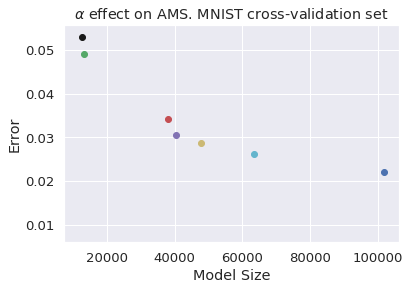

In [11]:
np_sizes = np.array(model_sizes)

np_cv_errors = 1 - np.array(cv_errors) #Used for accuracy error

#np_cv_errors = np.sqrt(np.array(cv_errors)) #Used for RMSE

np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_cv_errors[0], color = colors[0], label = 'alpha='+str(np_alphas[0]))
n2 = plt.scatter(np_sizes[1], np_cv_errors[1], color = colors[1], label = 'alpha='+str(np_alphas[1]))
n3 = plt.scatter(np_sizes[2], np_cv_errors[2], color = colors[2], label = 'alpha='+str(np_alphas[2]))
n4 = plt.scatter(np_sizes[3], np_cv_errors[3], color = colors[3], label = 'alpha='+str(np_alphas[3]))
n5 = plt.scatter(np_sizes[4], np_cv_errors[4], color = colors[4], label = 'alpha='+str(np_alphas[4]))
n6 = plt.scatter(np_sizes[5], np_cv_errors[5], color = colors[5], label = 'alpha='+str(np_alphas[5]))
n7 = plt.scatter(np_sizes[6], np_cv_errors[6], color = colors[6], label = 'alpha='+str(np_alphas[6]))

#plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')

#plt.title(r'$\alpha$'+' effect on AMS. MNIST cross-validation set')
#plt.savefig('alpha_ams_mnist_cvset.png', bbox_inches='tight', dpi=300)

plt.title(r'$\alpha$'+' effect on AMS. MNIST cross-validation set')
plt.savefig('alpha_ams_mnist_cvset.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

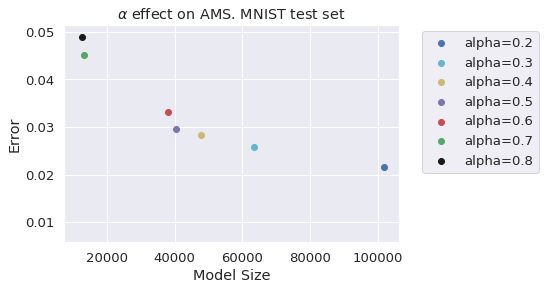

In [10]:
np_sizes = np.array(model_sizes)
str_alphas = str(alphas)

np_test_errors = 1 - np.array(test_errors) #Used for accuracy error

#np_test_errors = np.sqrt(np.array(test_errors)) #Used for RMSE

np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_test_errors[0], color = colors[0], label = 'alpha='+str(np_alphas[0]))
n2 = plt.scatter(np_sizes[1], np_test_errors[1], color = colors[1], label = 'alpha='+str(np_alphas[1]))
n3 = plt.scatter(np_sizes[2], np_test_errors[2], color = colors[2], label = 'alpha='+str(np_alphas[2]))
n4 = plt.scatter(np_sizes[3], np_test_errors[3], color = colors[3], label = 'alpha='+str(np_alphas[3]))
n5 = plt.scatter(np_sizes[4], np_test_errors[4], color = colors[4], label = 'alpha='+str(np_alphas[4]))
n6 = plt.scatter(np_sizes[5], np_test_errors[5], color = colors[5], label = 'alpha='+str(np_alphas[5]))
n7 = plt.scatter(np_sizes[6], np_test_errors[6], color = colors[6], label = 'alpha='+str(np_alphas[6]))

plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')

#plt.title(r'$\alpha$'+' effect on AMS. MNIST test set')
#plt.savefig('alpha_ams_mnist_testset.png', bbox_inches='tight', dpi=300)

plt.title(r'$\alpha$'+' effect on AMS. MNIST test set')
plt.savefig('alpha_ams_mnist_testset.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()